# kNN & Clustering

__Суммарное количество баллов: 10__

## kNN и рак (3 балла)

В этом части домашнего задания Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas

### 1. Данные (0.5 балла)


Реализуйте метод `read_cancer_dataset` . Он принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`.

In [2]:
CANCER_DATA_PATH = "cancer.csv"

In [3]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    df = pandas.read_csv(path_to_csv)
    classes = sorted(set(df["label"]))
    return df.drop(labels="label", axis=1), df["label"].replace({cl: i for i, cl in enumerate(classes)})

In [4]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
y_cancer.describe()

count    569.000000
mean       0.372583
std        0.483918
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: label, dtype: float64

Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.7`.

In [5]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    df = X.merge(y, left_index=True, right_index=True)
    df = df.sample(frac=1.0)
    top = int(len(df) * ratio)
    X_train = df[:top].drop("label", axis=1)
    y_train = df[:top]["label"]
    X_test = df[top:].drop("label", axis=1)
    y_test = df[top:]["label"]
    return X_train, y_train, X_test, y_test

### 2. Метрики (0.5 балла)

Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [6]:
def get_precision_recall_accuracy(y_pred, y_true):
    # Возвращает precision, recall и accuracy
    # precision - набор значений метрики precision для каждого класса
    # recall - набор значений метрики recall для каждого класса
    # accuracy - число, отражающее общую точность предсказания
    classes = sorted(set(np.unique(list(y_pred) + list(y_true))))
    precision = []
    recall = []
    correctly_guessed = (y_pred == y_true)
    for cl in classes:
        cl_true = (y_true == cl)
        cl_pred = (y_pred == cl)
        precision.append(sum(cl_true&cl_pred)/sum(cl_pred))
        recall.append(sum(cl_true&cl_pred)/sum(cl_true))
#         print(len(y_pred), sum(cl_true&cl_pred), sum(cl_pred), sum(cl_true))
    accuracy = sum(correctly_guessed) / len(y_true)
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [7]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [8]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c, k in zip(curves_tpr, curves_fpr, colors, ks):
        plt.plot(fpr, tpr, color=c, label=f"k={k}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.legend()
    plt.show()

## 3. KNN (2 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево. (При желании можно воспользоваться библиотечной реализацией дерева)

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать вероятности классов для заданного набора данных основываясь на классах соседей

In [9]:
from sklearn.neighbors import KDTree

class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self._n_neighbors = n_neighbors
        self._leaf_size = leaf_size
        self._tree = None
        self._y = None
    
    def fit(self, X, y):
        self._tree = KDTree(X, leaf_size=self._leaf_size)
        self._y = np.array(y)
        self._classes = np.array(sorted(set(y)))
        
    def predict_proba(self, X):
        # Возвращает матрицу, в которой строки соответствуют элементам X, а столбцы - классам. На пересечении строки и столбца должна быть указана вероятность того, что элемент относится к классу
        # Вероятность рассчитывается как количество ближайших соседей с данным классом деленное на общее количество соседей
        result = np.zeros((len(X), len(self._classes)))
        knn = self._tree.query(X, k=self._n_neighbors, return_distance=False)
        for i, nn in enumerate(knn):
            cls = self._y[nn]
            for j, cl in enumerate(self._classes):
                result[i, j] = sum(cls == cl) / self._n_neighbors
#         print(result)
        return result
        
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на датасете _cancer_

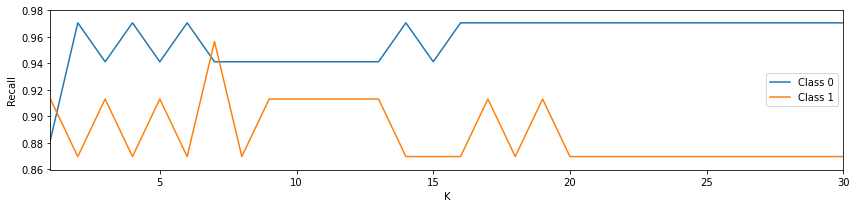

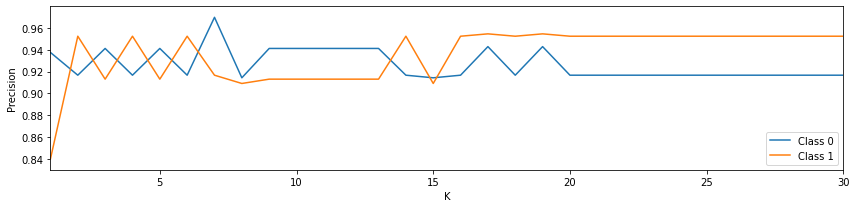

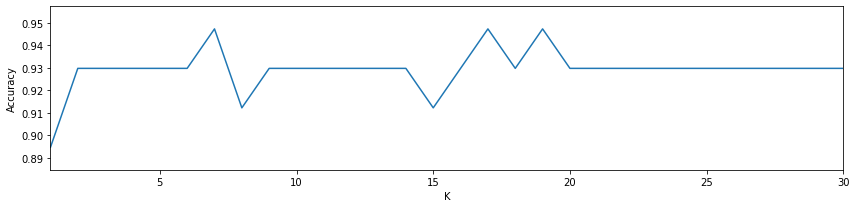

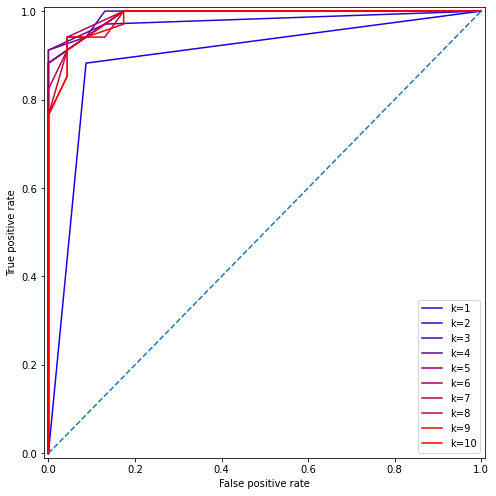

In [10]:
X_train, y_train, X_test, y_test = train_test_split(X_cancer, y_cancer, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)



Проанализируйте полученные графики. Какой параметр `k` кажется лучшим? Какая из метрик лучше всего отражает качество модели? 

_Начиная с $k=2$ не видно дальнейшего улучшения качества, так что лучшим кажется $k=2$._

_AUC выглядит лучшей метрикой._

## Clustering (7 баллов)

В этой части домашнего задания предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [19]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [20]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

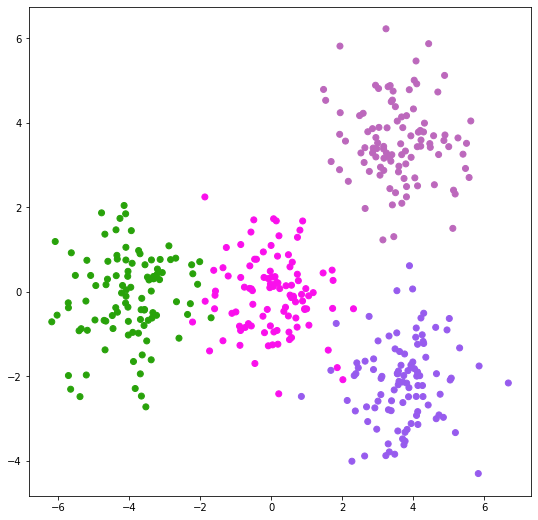

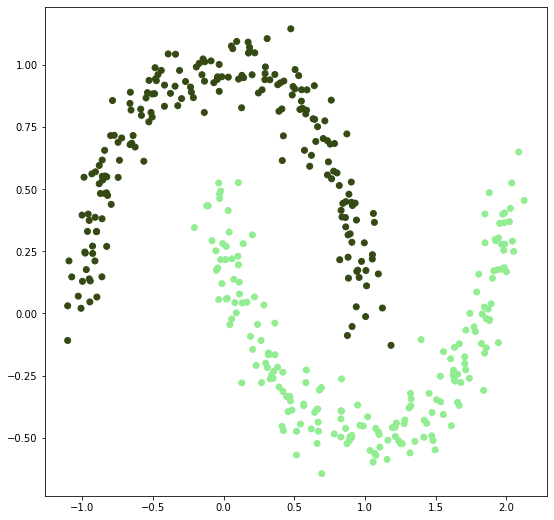

In [21]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### 1. K-means (2.5 балла)

Первый метод, который предлагается реализовать - метод K средних.

__Описание методов__

`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

__Инициализация кластеров__

Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

In [106]:
import collections
import random

class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self._n_clusters = n_clusters
        self._init = init
        self._max_iter = max_iter
        self._clusters = None
        
    def fit(self, X, y=None):
        self._init_clusters(X)
        for _ in range(self._max_iter):
            classes = [
                min((np.linalg.norm(x-c), i) for i, c in enumerate(self._clusters))[1]
                for x in X
            ]  # x index -> cluster index
            cluster_to_xs = collections.defaultdict(list)
            for x_index, cluster_index in enumerate(classes):
                cluster_to_xs[cluster_index].append(X[x_index, :])
            for cluster_index, xs in cluster_to_xs.items():
                self._clusters[cluster_index] = np.mean(xs, axis=0)

    def _init_clusters(self, X):
        n, d = X.shape
        if self._init == "random":
            l, h = np.min(X), np.max(X)
            self._clusters = np.random.uniform(low=l, high=h, size=(self._n_clusters, d))
        elif self._init == "sample":
            indices = random.sample(range(n), self._n_clusters)
            self._clusters = X[indices, :]
        elif self._init == "k-means++":
            index = random.choice(range(n))
            centers = [X[index, :]]
            for _ in range(1, self._n_clusters):
                distances = [
                    min(np.linalg.norm(x-c) for c in centers)**2
                    for x in X
                ]
                best_index, = random.choices(range(n), weights=distances)
                centers.append(X[best_index, :])
            self._clusters = centers
            
    
    def predict(self, X):
        return np.array([
            min((np.linalg.norm(x-c), i) for i, c in enumerate(self._clusters))[1]
            for x in X
        ])


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

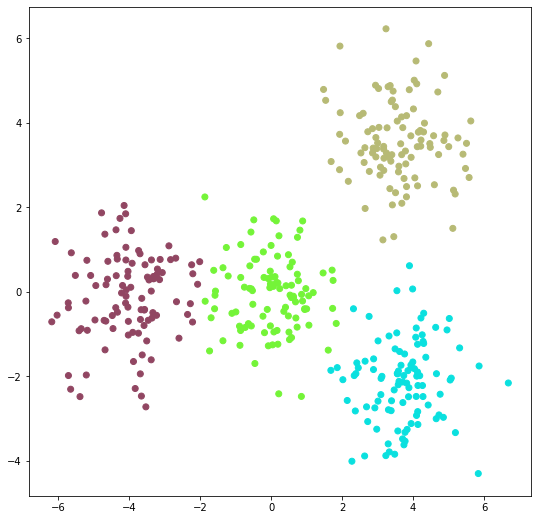

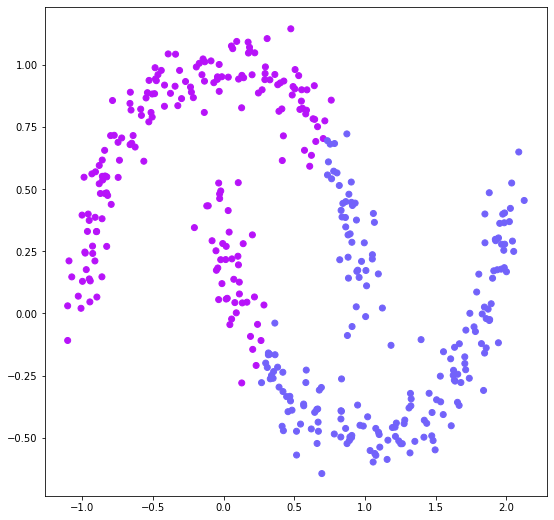

In [107]:
kmeans = KMeans(n_clusters=4, init="sample", max_iter=20)
kmeans.fit(X_1)
labels_kmeans_1 = kmeans.predict(X_1)
visualize_clasters(X_1, labels_kmeans_1)

kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=20)
kmeans.fit(X_2)
labels_kmeans_2 = kmeans.predict(X_2)
visualize_clasters(X_2, labels_kmeans_2)

### 2. DBScan (3.5 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

__Описание методов__

`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

__Возможные метрики__

* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [133]:
NOISE = 0

class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self._eps = eps
        self._min_samples = min_samples
        self._leaf_size = leaf_size
        self._metric = metric
        
    def fit_predict(self, X, y=None):
        tree = KDTree(X, leaf_size=self._leaf_size, metric=self._metric)
        n = X.shape[0]
        c = 0
        labels = [None] * n
        for i in range(n):
            if labels[i] is not None:
                continue
            indices, = tree.query_radius(X[i:i+1, :], self._eps, return_distance=False)
            if len(indices) < self._min_samples:
                labels[i] = NOISE
                continue
            c += 1
            labels[i] = c
            visited = {i}
            indices = set(indices) - visited
            while indices:
                j = indices.pop()
                visited.add(j)
                if labels[j] == NOISE:
                    labels[j] = c
                if labels[j] is not None:
                    continue
                labels[j] = c
                next_indices, = tree.query_radius(X[j:j+1, :], self._eps, return_distance=False)
                if len(next_indices) >= self._min_samples:
                    indices.update(set(next_indices) - visited)
        labels = np.array(labels)
        if not np.any(labels == 0):
            labels -= 1
        return labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

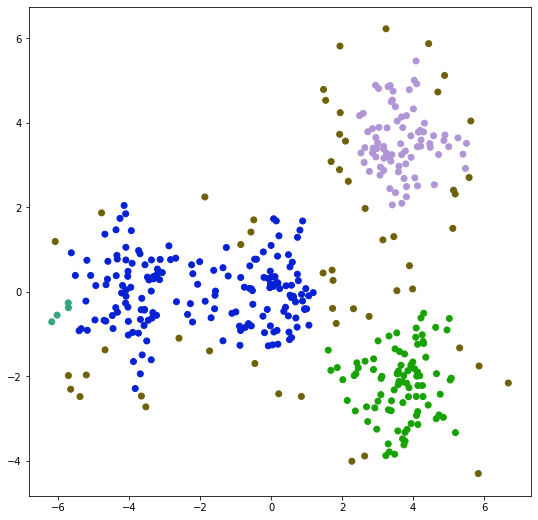

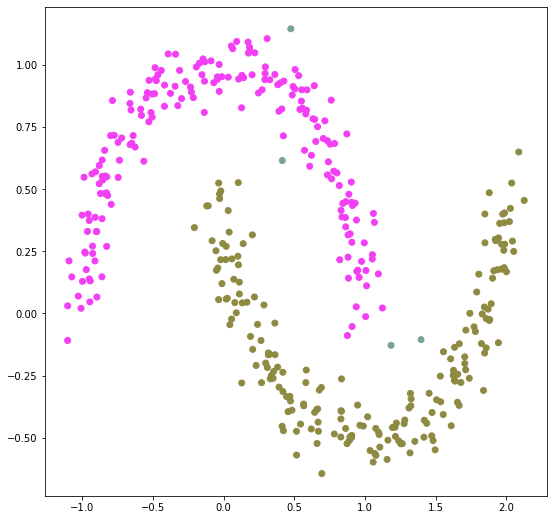

In [134]:
dbscan = DBScan(eps=0.5, min_samples=4)
labels_dbscan_1 = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels_dbscan_1)

dbscan = DBScan(eps=0.15)
labels_dbscan_2 = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels_dbscan_2)

### 3. Оценка качества моделей (1 балл)
Проанализируйте полученные результаты. 

Какой метод лучше справился с кластеризацией? Почему? 

Сравните значения метрик  `Davies-Bouldin index` и `Silhouette score` для определения качества кластеризации. 

Какие значения метрики свидетельствуют о хорошей кластеризации - большие или маленькие?

_На датасете с облаками точек K-Means справился лучше, а также устойчивее — при разных радиусах DBSCAN так  и норовил склеить/расклеить ещё какие-то из трёх-четырёх кластеров. На датасете с изгибами DBSCAN справился лучше, уловив форму кластеров._

In [135]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import pandas as pd

In [136]:
print("Davies-Bouldin score:")
pd.DataFrame(data=[
    [davies_bouldin_score(X_1, labels_kmeans_1), davies_bouldin_score(X_1, labels_dbscan_1)],
    [davies_bouldin_score(X_2, labels_kmeans_2), davies_bouldin_score(X_2, labels_dbscan_2)],
], index=["X1", "X2"], columns=["K-means", "DBSCAN"])

Davies-Bouldin score:


,K-means,DBSCAN
X1,0.534762,1.364194
X2,0.773648,2.273854


In [137]:
print("Silhouette score:")
pd.DataFrame(data=[
    [silhouette_score(X_1, labels_kmeans_1), silhouette_score(X_1, labels_dbscan_1)],
    [silhouette_score(X_2, labels_kmeans_2), silhouette_score(X_2, labels_dbscan_2)],
], index=["X1", "X2"], columns=["K-means", "DBSCAN"])

Silhouette score:


,K-means,DBSCAN
X1,0.599328,0.286990
X2,0.492576,0.110722


_Для davies_bouldin_score лучшую кластеризацию означают значения ближе к нулю, для silhouette_score — значения ближе к 1._

_Однако, эти числа замусорены неклассифицировавшимися в случае DBSCAN точками._

In [145]:
good_indices_1, = np.where(labels_dbscan_1 != 0)
good_indices_2, = np.where(labels_dbscan_2 != 0)

In [143]:
print("Davies-Bouldin score:")
pd.DataFrame(data=[
    [davies_bouldin_score(X_1[good_indices_1], labels_kmeans_1[good_indices_1]), davies_bouldin_score(X_1[good_indices_1], labels_dbscan_1[good_indices_1])],
    [davies_bouldin_score(X_2[good_indices_2], labels_kmeans_2[good_indices_2]), davies_bouldin_score(X_2[good_indices_2], labels_dbscan_2[good_indices_2])],
], index=["X1", "X2"], columns=["K-means", "DBSCAN"])

Davies-Bouldin score:


,K-means,DBSCAN
X1,0.47500,0.531243
X2,0.77409,1.147168


In [144]:
print("Silhouette score:")
pd.DataFrame(data=[
    [silhouette_score(X_1[good_indices_1], labels_kmeans_1[good_indices_1]), silhouette_score(X_1[good_indices_1], labels_dbscan_1[good_indices_1])],
    [silhouette_score(X_2[good_indices_2], labels_kmeans_2[good_indices_2]), silhouette_score(X_2[good_indices_2], labels_dbscan_2[good_indices_2])],
], index=["X1", "X2"], columns=["K-means", "DBSCAN"])

Silhouette score:


,K-means,DBSCAN
X1,0.650686,0.431773
X2,0.492632,0.331881


_По метрикам K-means везде победил 🤷🏼‍♂️_